## Imports

In [168]:
import os
from os.path import join as opj
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from transformers import AutoTokenizer

## Read the data

In [169]:
TEST_PATH = "../data/processed/test"
df_dict = {}
for name in os.listdir(TEST_PATH):
    df_dict[name.split(".")[0]] = pd.read_csv(opj(TEST_PATH, name))
if "sigmoid" in df_dict:
    df_dict['rkl'] = df_dict.pop("sigmoid")

In [170]:
for key in sorted(list(df_dict.keys())):
    print(f'{key}: {len(df_dict[key])}')

alpha_03: 12487
alpha_05: 12442
alpha_07: 12405
cdpo_015: 12390
dpo_annealing: 12443
fkl: 12342
hinge: 12459
ipo_01: 12316
ipo_03: 12202
ipo_05: 12190
ipo_annealing: 12227
jsd: 12485
rkl: 12465
sft: 11786


## Helpers

In [171]:
def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0

    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1

    for k in stats.keys():
        stats[k] /= num_tokens

    return entropy(list(stats.values()))

def calculate_average_entropy(df, tokenizer):
    """
    Calculate the average entropy for each unique generation ID.
    
    :param df: DataFrame with 'gen_id' and 'response' columns
    :param tokenizer: tokenizer object
    :return: average entropy value
    """
    # Group by 'gen_id' and calculate entropy for each group
    entropies = df.groupby('gen_id')['response'].apply(lambda x: token_entropy(x, tokenizer))
    
    # Calculate and return the average entropy
    return entropies.mean()

def plot_entropy_vs_reward(df_dict, tokenizer, only_all=False, per_gen_id=True):
    if only_all:
        fig, ax = plt.subplots(figsize=(7, 7))
        axes = [ax]
        labels = ["all"]
    else:
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))
        labels = {0: "neg", 1: "pos", "all": "all"}

    palette = sns.color_palette(n_colors=len(df_dict))

    for i, label in enumerate(labels):
        rewards = []
        entropies = []

        for j, (key, df) in enumerate(df_dict.items()):
            if label != "all" and not only_all:
                filtered_df = df[df["label"] == label]
            else:
                filtered_df = df

            avg_reward = filtered_df["reward"].mean()
            if per_gen_id:
                avg_entropy = calculate_average_entropy(filtered_df, tokenizer)
            else:
                avg_entropy = token_entropy(filtered_df['response'], tokenizer)


            if key in ["alpha_03", "alpha_05", "alpha_07", "fkl", "jsd", "rkl"]:
                rewards.append(avg_reward)
                entropies.append(avg_entropy)

            axes[i].scatter(
                avg_reward, avg_entropy, s=100, marker="x", label=key, color=palette[j]
            )
            axes[i].annotate(
                key,
                (avg_reward, avg_entropy),
                textcoords="offset points",
                xytext=(10, 10),
                ha="center",
                color=palette[j],
            )

        if len(rewards) > 1:
            regression_coeffs = np.polyfit(rewards, entropies, 2)
            regression_line = np.poly1d(regression_coeffs)
            x = np.linspace(min(rewards) - 0.01, max(rewards) + 0.01, 100)
            axes[i].plot(x, regression_line(x), "--", color="gray")

        axes[i].set_title(f"Label = {label if only_all else labels[label]}")
        axes[i].set_xlabel("Reward")
        axes[i].set_ylabel("Entropy")
        if i == 2 or only_all:
            axes[i].legend()

    plt.tight_layout()
    plt.show()


In [130]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")

## Level 1

In [140]:
from pprint import pprint

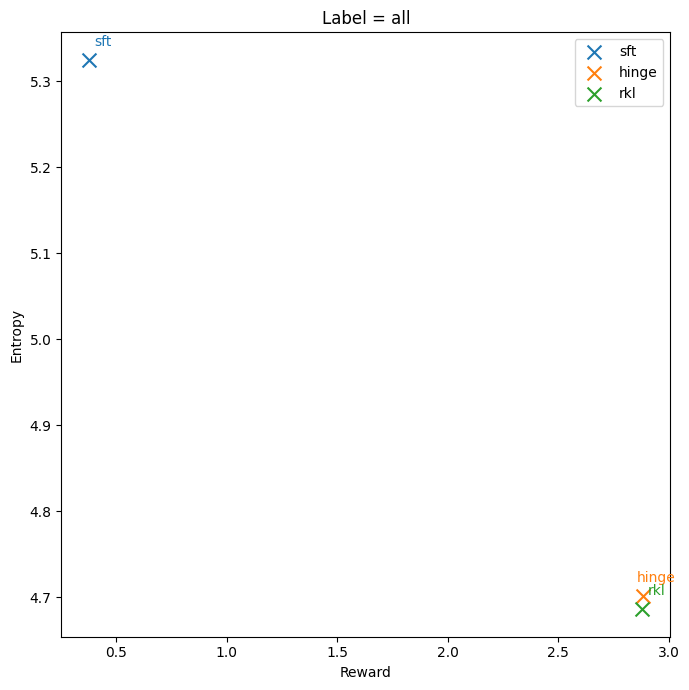

In [172]:
types = ['sft', 'hinge', 'rkl']
lvl1_dict = {k: df_dict.get(k) for k in types}
plot_entropy_vs_reward(lvl1_dict, tokenizer, True)

## Level 2

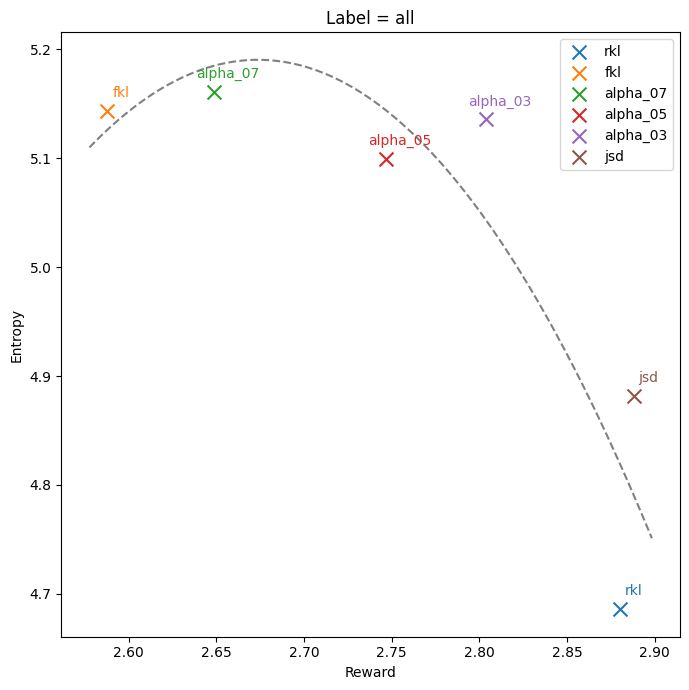

In [174]:
types = ['rkl', 'fkl', 'alpha_07', "alpha_05", "alpha_03", "jsd"]
lvl2_dict = {k: df_dict.get(k) for k in types}
plot_entropy_vs_reward(lvl2_dict, tokenizer, True, True)

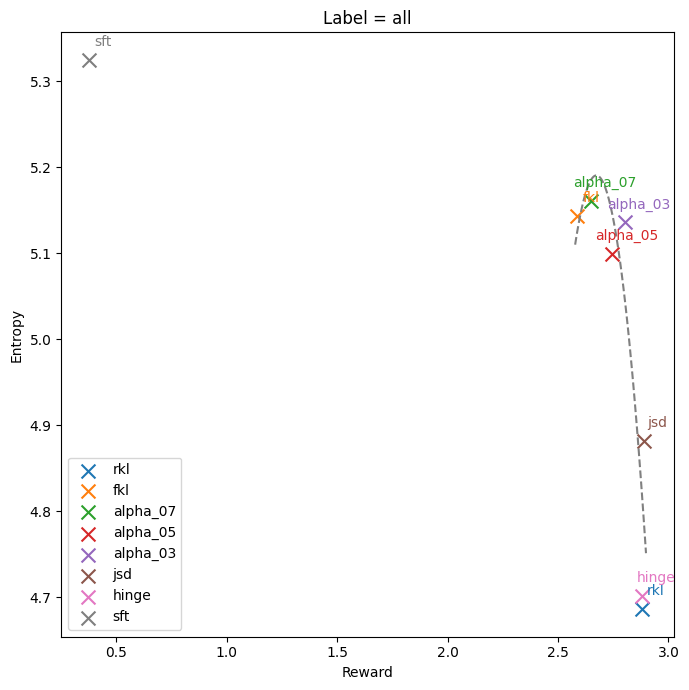

In [176]:
types = ['rkl', 'fkl', 'alpha_07', "alpha_05", "alpha_03", "jsd", 'hinge', 'sft']
lvl2_dict = {k: df_dict.get(k) for k in types}
plot_entropy_vs_reward(lvl2_dict, tokenizer, True)

## Level 3

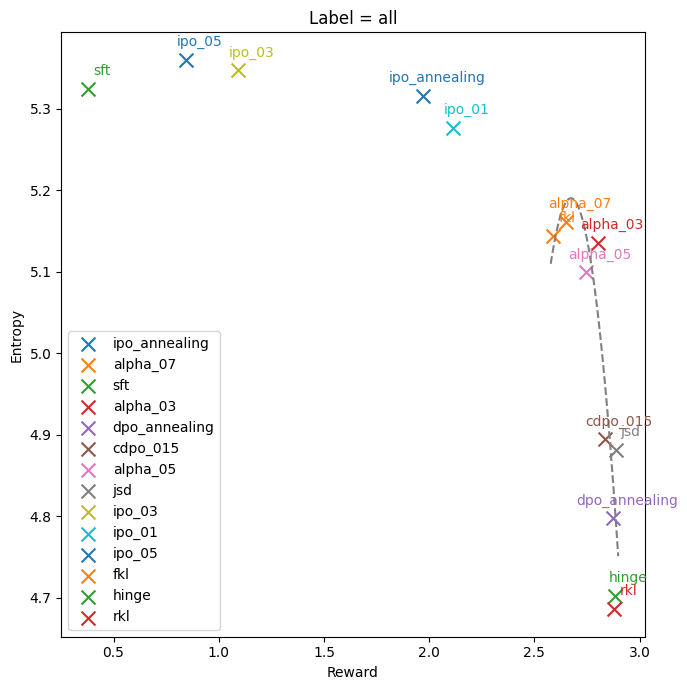

In [178]:
plot_entropy_vs_reward(df_dict, tokenizer, True)

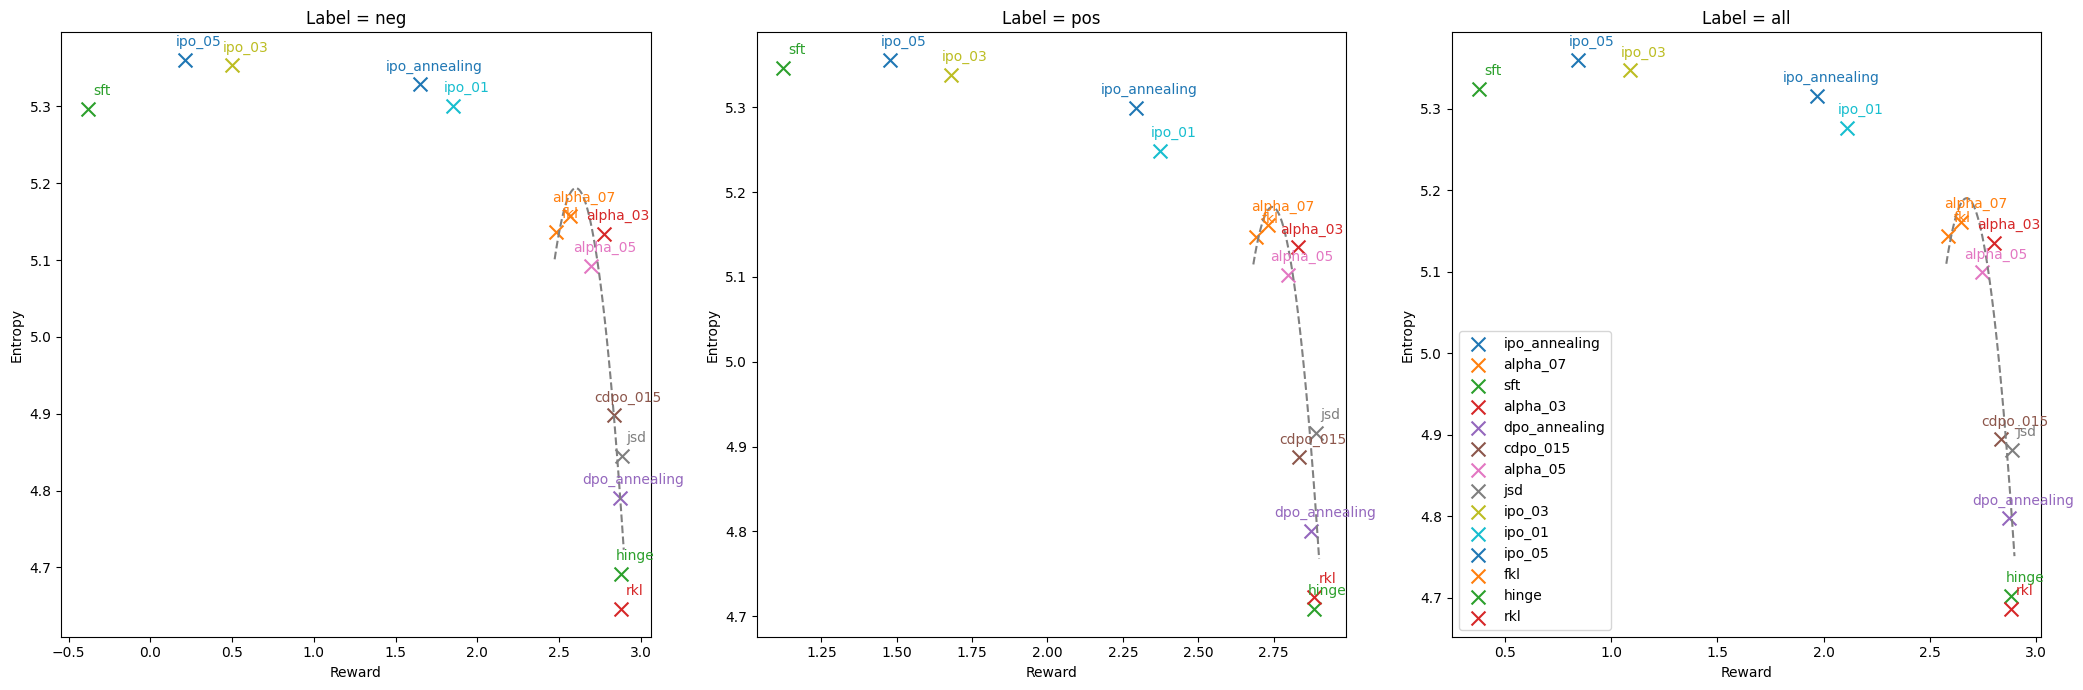

In [179]:
plot_entropy_vs_reward(df_dict, tokenizer)

## Среднее Beta с учетом Cosine Scheduler

In [181]:
lr_max = 1e-05  # максимальное значение lr
lr_min = 0  # минимальное значение lr
N = 7193  # общее количество шагов
beta_start = 1.0  # начальное значение beta
beta_end = 0.0  # конечное значение beta

# Функция для вычисления величины lr на каждом шаге
def lr_schedule(step, N, lr_max, lr_min):
    return 0.5 * (1 + np.cos(step / N * np.pi)) * (lr_max - lr_min) + lr_min

# Веса для каждого шага
weights = np.array([lr_schedule(i, N, lr_max, lr_min) / lr_max for i in range(150, N)])

# Значения beta для каждого шага
betas = np.linspace(beta_start-(1/N)*150, beta_end, N-150)

# Расчет средневзвешенного значения beta
beta_avg_weighted = np.sum(betas * weights) / np.sum(weights)
beta_avg_weighted

0.6901598684689689